Priors
======

Learn how you can include prior knowledge into the fitting by setting
priors on single parameters.

Prerequisites
-------------

-  Knowledge of spectral analysis to produce 1D spectral datasets, see
   the :doc:`/tutorials/analysis-1d/spectral_analysis` tutorial.
-  Knowledge of fitting models to datasets, see
   :doc:`/tutorials/api/fitting` tutorial
-  General knowledge of statistics and priors

Context
-------

Generally, the set of parameters describing best the data is where the
fit statistic :math:`2 x log L` has its global minimum. Depending on
the type of background estimation, it is either the Cash fit statistic
or the WStat (see :doc:`/user-guide/stats/fit_statistics` for more
details).

A prior on the value of some of the parameters can be added to this fit
statistic. The prior is again a probability density function of the
model parameters and can take different forms, including Gaussian
distributions, uniform distributions, etc. The prior includes
information or knowledge about the dataset or the parameters of the fit.

Setting priors on multiple parameters simultaneously is supported,
However, for now, they should not be correlated.

The spectral dataset used here contains a simulated power-law source and
its IRFs are based on HESS data of the Crab Nebula (similar to
:doc:`/tutorials/api/fitting`). We are simulating the source here, so
that we can control the input and check the correctness of the fit
results.

The tutorial addresses three examples:

1. Including prior information about the sources index
2. Encouraging positive amplitude values
3. How to add a custom prior class?

In the first example, the Gaussian prior is used. It is shown how to set
a prior on a model parameter and how it modifies the fit statistics. A
source is simulated without statistics and fitted with and without the
priors. The different fit results are discussed.

For the second example, 1000 datasets containing a very weak source are
simulated. Due to the statistical fluctuations, the amplitude’s best-fit
value is negative for some draws. By setting a uniform prior on the
amplitude, this can be avoided.

The setup
---------




System:

	python_executable      : /home/katrin/anaconda3/envs/gammapy-dev/bin/python 
	python_version         : 3.9.16     
	machine                : x86_64     
	system                 : Linux      


Gammapy package:

	version                : 1.2.dev1226+g03b1e9022.d20231204 
	path                   : /home/katrin/Documents/gammapy/gammapy 


Other packages:

	numpy                  : 1.25.1     
	scipy                  : 1.11.1     
	astropy                : 5.3.1      
	regions                : 0.7        
	click                  : 8.1.6      
	yaml                   : 6.0        
	IPython                : 8.14.0     
	jupyterlab             : 3.5.3      
	matplotlib             : 3.7.2      
	pandas                 : 2.0.3      
	healpy                 : 1.16.3     
	iminuit                : 2.22.0     
	sherpa                 : 4.15.1     
	naima                  : 0.10.0     
	emcee                  : 3.1.4      
	corner                 : 2.2.2      
	ray                    :

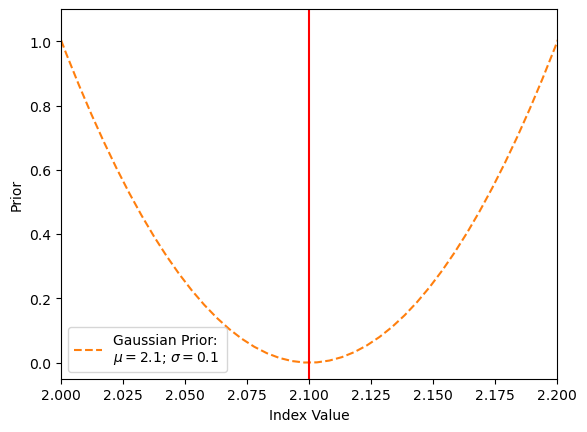

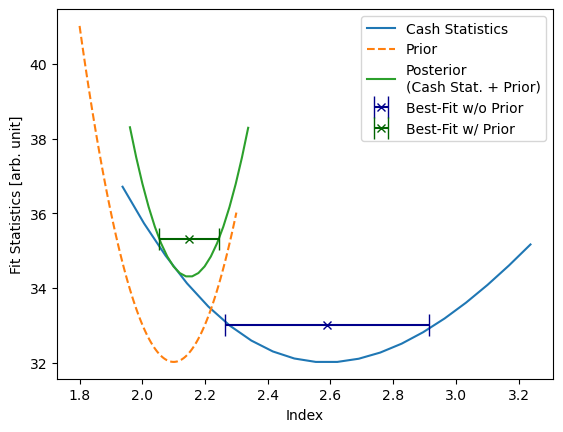

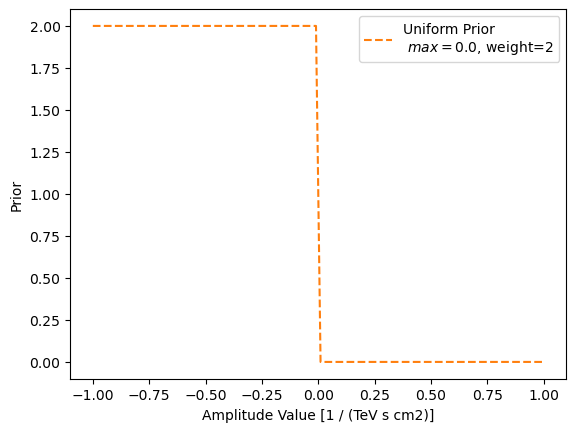

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: i

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: i

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning

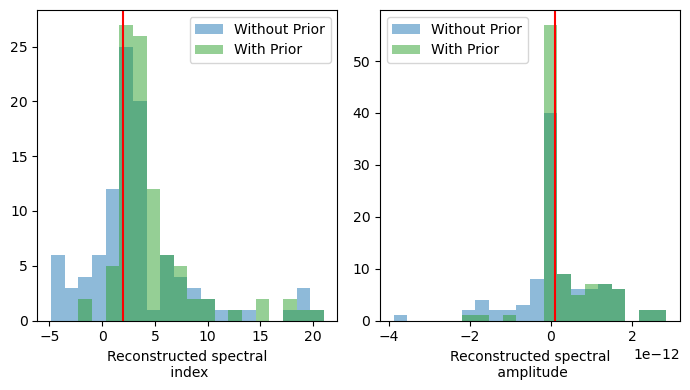

In [5]:
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt
from gammapy.datasets import Datasets, SpectrumDatasetOnOff
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    GaussianPrior,
    Models,
    PowerLawSpectralModel,
    SkyModel,
    UniformPrior,
)
from gammapy.utils.check import check_tutorials_setup

######################################################################
# Check setup
# -----------
#


check_tutorials_setup()


######################################################################
# Model and dataset
# -----------------
#
# First, we define the source model, a power-law with an index of
# :math:`2.3`
#

pl_spectrum = PowerLawSpectralModel(
    index=2.3,
    amplitude=1e-11 / u.cm**2 / u.s / u.TeV,
)
model = SkyModel(spectral_model=pl_spectrum, name="simu-source")


######################################################################
# The data and background are read from pre-computed ON/OFF datasets of
# HESS observations. For simplicity, we stack them together and transform
# the dataset to a `SpectrumDataset`. Then we set the model and create
# an Asimov dataset (dataset without statistics) by setting the counts as
# the model predictions.
#

dataset = SpectrumDatasetOnOff.read(
    f"$GAMMAPY_DATA/joint-crab/spectra/hess/pha_obs23523.fits"
)

# Set model and fit range
e_min = 0.66 * u.TeV
e_max = 30 * u.TeV
dataset.mask_fit = dataset.counts.geom.energy_mask(e_min, e_max)
dataset = dataset.to_spectrum_dataset()

dataset1 = dataset.copy()
dataset1.models = model.copy(name="model")
dataset1.counts = dataset1.npred()


######################################################################
# Example 1: Including Prior Information about the Sources Index
# --------------------------------------------------------------
#
# The index was assumed to be :math:`2.3`. However, let us assume you
# have reasons to believe that the index value of the source is actually
# :math:`2.1`. This can be due to theoretical predictions, other
# instruments’ results, etc. We can now create a Gaussian distributed
# prior with a minimum at the expected value of :math:`2.1`. The standard
# deviation of the Gaussian quantifies how much we believe the prior
# knowledge to be true. The smaller the standard deviation, the stronger
# the constraining ability of the prior. For now, we set it to the
# arbitrary value of :math:`0.1`.
#

# initialising the gaussian prior
gaussianprior = GaussianPrior(mu=2.1, sigma=0.1)
# setting the gaussian prior on the index parameter
model_prior = model.copy()
model_prior.parameters["index"].prior = gaussianprior


######################################################################
# The value of the prior depends on the value of the index. If the index
# value equals the Gaussians mean (here 2.1), the prior is zero. This
# means that nothing is added to the cash statistics, and this value is
# favoured in the fit. If the value of the index deviates from the mean of
# 2.1, a prior value > 0 is added to the cash statistics.
#

# For the visualisation, the values are appended to the list; this is not a necessity for the fitting
prior_stat_sums = []
with model_prior.parameters.restore_status():
    i_scan = np.linspace(1.8, 2.3, 100)
    for a in i_scan:
        model_prior.parameters["index"].value = a
        prior_stat_sums.append(model_prior.parameters.prior_stat_sum())

plt.plot(
    i_scan,
    prior_stat_sums,
    color="tab:orange",
    linestyle="dashed",
    label=f"Gaussian Prior: \n$\mu = {gaussianprior.mu.value}$; $\sigma = {gaussianprior.sigma.value}$",
)
plt.axvline(x=gaussianprior.mu.value, color="red")

plt.xlabel("Index Value")
plt.ylabel("Prior")
plt.legend()
plt.xlim(2.0, 2.2)
plt.ylim(-0.05, 1.1)
plt.show()


######################################################################
# Fitting a Dataset with and without the Prior
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
# Now, we copy the dataset consisting of the power-law source and assign
# the model with the Gaussian prior set on its index to it. Both of the
# datasets are fitted.
#
dataset1.fake()
dataset1_prior = dataset1.copy()
dataset1_prior.models = model_prior.copy(name="prior-model")

fit = Fit()
results = fit.run(dataset1)

results_prior = fit.run(dataset1_prior)


######################################################################
# The Likelihood profiles can be computed for both the datasets. Hereby,
# the likelihood gets computed for different values of the index. For each
# step the other free parameters are getting reoptimized.
#

dataset1.models.parameters["index"].scan_n_values = 20
dataset1_prior.models.parameters["index"].scan_n_values = 20

scan = fit.stat_profile(datasets=dataset1, parameter="index", reoptimize=True)

scan_prior = fit.stat_profile(
    datasets=dataset1_prior, parameter="index", reoptimize=True
)


######################################################################
# Now, we can compare the two Likelihood scans. In the first case, we did
# not set any prior. This means that only the Cash Statistic itself is
# getting minimized. The Cash statistics minimum is the actual value of
# the index we used for the simulation (:math:`2.3`). Therefore, the
# best-fit value was found to be :math:`2.3`. Note how the error bars
# correspond to the :math:`1\sigma` error, i.e. where the stat sum equals
# the minimum + 1.
#
# The plot also shows the prior we set on the index for the second
# dataset. The scan was computed above. If the logarithm of the prior is added to the cash
# statistics, one ends up with the posterior function. The posterior is
# minimized during the second fit to obtain the maximum a posteriori estimation. Its minimum is between the priors and
# the cash statistics minimum. The best-fit value is :math:`2.16`. We
# weighed the truth with our prior beliefs and ended up with a compromise
# between the values. The uncertainty of the parameter is again where the
# posterior distributions equal its minimum + 1.
#
# The best-fit index value and uncertainty depend strongly on the standard
# deviation of the Gaussian prior. You can vary :math:`\sigma` and see how
# the Likelihood profiles and corresponding minima will change.
#

plt.plot(scan["model.spectral.index_scan"], scan["stat_scan"], label="Cash Statistics")
plt.plot(
    i_scan,
    np.array(prior_stat_sums) + np.min(scan["stat_scan"]),
    linestyle="dashed",
    label="Prior",
)
plt.plot(
    scan_prior["prior-model.spectral.index_scan"],
    scan_prior["stat_scan"],
    label="Posterior\n(Cash Stat. + Prior)",
)

par = dataset1.models.parameters["index"]
plt.errorbar(
    x=par.value,
    y=np.min(scan["stat_scan"]) + 1,
    xerr=par.error,
    fmt="x",
    markersize=6,
    capsize=8,
    color="darkblue",
    label="Best-Fit w/o Prior",
)
par = dataset1_prior.models.parameters["index"]
plt.errorbar(
    x=par.value,
    y=np.min(scan_prior["stat_scan"]) + 1,
    xerr=par.error,
    fmt="x",
    markersize=6,
    capsize=8,
    color="darkgreen",
    label="Best-Fit w/ Prior",
)
plt.legend()
# plt.ylim(31.5,35)
plt.xlabel("Index")
plt.ylabel("Fit Statistics [arb. unit]")
plt.show()


######################################################################
# This example shows a critical note on using priors: we were able to
# manipulate the best-fit index. This can have multiple advantages if one
# wants to include additional information. But it should always be used
# carefully to not falsify or bias any results!
#
# Note how the :math:`\Delta`\ TS of the dataset with the prior set is
# larger (:math:`-53.91`) than the one without prior (:math:`-55.03`)
# since the index is not fitted to the underlying true value. If the
# Gaussian priors mean were the true value of :math:`2.3`, the index would
# be fitted correctly, and the :math:`\Delta`\ TS values would be the
# same.
#


######################################################################
# Example 2: Encouraging Positive Amplitude Values
# ------------------------------------------------
#
# In the next example, we want to encourage the amplitude to have
# positive, i.e. physical, values. Instead of setting hard bounds, we can
# also set a uniform prior, which prefers positive values over negatives.
#
# We set the amplitude of the power-law used to simulate the source very
# small. Together with statistical fluctuations, this will result in some
# negative amplitude best-fit values.
#

model_weak = SkyModel(
    PowerLawSpectralModel(
        amplitude=1e-13 / u.cm**2 / u.s / u.TeV,
    ),
    name="weak-model",
)
model_weak_prior = model_weak.copy(name="weak-model-prior")
uniform = UniformPrior(max=0)
uniform.weight = 2
model_weak_prior.parameters["amplitude"].prior = uniform


######################################################################
# We set the maximum value where the prior is applied to zero. Note that,
# per default, the minimum value is set to negative infinity. Therefore, the
# uniform prior is zero, i.e. no influence on the fit at all if the
# amplitude value is positive.
#
# The weight of the prior again quantifies how strong we want prior to
# being. Here, we are setting it to 2. This value is only applied if the
# amplitude value is below zero.
#

uni_prior_stat_sums = []
with model_weak_prior.parameters.restore_status():
    a_scan = np.linspace(-1, 1, 100)
    for a in a_scan:
        model_weak_prior.parameters["amplitude"].value = a
        uni_prior_stat_sums.append(model_weak_prior.parameters.prior_stat_sum())

plt.plot(
    a_scan,
    uni_prior_stat_sums,
    color="tab:orange",
    linestyle="dashed",
    label=f"Uniform Prior\n $max={uniform.max.value}$, weight={uniform.weight}",
)
plt.xlabel("Amplitude Value [1 / (TeV s cm2)]")
plt.ylabel("Prior")
plt.legend()
plt.show()

######################################################################
# Fitting Multiple Datasets with and without the Prior
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
# To showcase how the uniform prior affects the fit results, :math:`100`
# datasets are created and fitted without and with the prior
#

results, results_prior = [], []
N = 100
dataset2 = dataset.copy()
for n in range(N):
    # simulating the dataset
    dataset2.models = model_weak.copy()
    dataset2.fake()

    dataset2_prior = dataset2.copy()
    dataset2_prior.models = model_weak_prior.copy()
    # fitting without the prior
    fit = Fit()
    result = fit.optimize(dataset2)
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
        }
    )
    # fitting with the prior
    fit_prior = Fit()
    result = fit_prior.optimize(dataset2_prior)
    results_prior.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
        }
    )


fig, axs = plt.subplots(1, 2, figsize=(7, 4))
for i, parname in enumerate(["index", "amplitude"]):
    par = np.array([_[parname] for _ in results])
    c, bins, _ = axs[i].hist(par, bins=20, alpha=0.5, label="Without Prior")
    par = np.array([_[parname] for _ in results_prior])
    axs[i].hist(par, bins=bins, alpha=0.5, color="tab:green", label="With Prior")
    axs[i].axvline(x=model_weak.parameters[parname].value, color="red")
    axs[i].set_xlabel(f"Reconstructed spectral\n {parname}")
    axs[i].legend()
plt.tight_layout()
plt.show()


######################################################################
# The distribution of the best-fit amplitudes shows how less best-fit
# amplitudes have negative values. This also has an effect on the
# distribution of the best-fit indices. How exactly the distribution
# changes depends on the weight assigned to the uniform prior. The
# stronger the weight, the less negative amplitudes.
#
# Note that the model parameters uncertainties are, per default, computed
# symmetrical. This can lead to incorrect
# uncertainties, especially with asymmetrical priors like the previous
# uniform. Calculating the uncertainties from the profile likelihood
# is advised. For more details see the :doc:`/tutorials/api/fitting` tutorial.
#

######################################################################
# Implementing a custom prior
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
# For now, only ``GaussianPrior`` and `UniformPrior`` are implemented.
# To add a use case specfific prior one has to create a prior subclass
# containing:
#
# - a tag and a _type used for the serialization
# - an instantiation of each PriorParameter with their unit and default values
# - the evaluate function where the mathematical expression for the prior
#    is defined.
# As an example for a custom prior a Jeffrey prior for a scale parameter is chosen.
# The only parameter is ``sigma`` and the evaluation method return the quared inverse of ``sigma``.



from gammapy.modeling import PriorParameter
from gammapy.modeling.models import Prior, Model


class MyCustomPrior(Prior):
    """Custom Prior.


    Parameters
    ----------
    min : float
        Minimum value.
        Default is -inf.
    max : float
        Maxmimum value.
        Default is inf.
    """

    tag = ["MyCustomPrior"]
    sigma = PriorParameter(name="sigma", value=1, unit="")
    _type = "prior"
    
    @staticmethod
    def evaluate(value, sigma):
        """Evaluate the costom prior."""
        return value / sigma**2
    
# The custom prior is added to the PRIOR_REGISTRY so that it can be serialised.    

from gammapy.modeling.models import PRIOR_REGISTRY
PRIOR_REGISTRY.append(MyCustomPrior)

In [6]:
# The custom prior is set on the index of a powerlaw spectral model and is evaluated. 
costomprior =  MyCustomPrior(sigma = 0.5)
pwl = PowerLawSpectralModel()
pwl.parameters['index'].prior = costomprior
costomprior(pwl.parameters['index'])

8.0

In [7]:
# The power law spectral model can be written into a dictionary. 
# If the a model is read in from this dictionary, the costum prior is still set on the index. 

print(pwl.to_dict())
model_read = Model.from_dict(pwl.to_dict())
model_read.parameters.prior

{'spectral': {'type': 'PowerLawSpectralModel', 'parameters': [{'name': 'index', 'value': 2.0, 'prior': {'type': 'MyCustomPrior', 'parameters': [{'name': 'sigma', 'value': 0.5, 'unit': ''}], 'weight': 1}}, {'name': 'amplitude', 'value': 1e-12, 'unit': 'TeV-1 s-1 cm-2'}, {'name': 'reference', 'value': 1.0, 'unit': 'TeV'}]}}


[<__main__.MyCustomPrior at 0x7f7707a32520>, None, None]